# Display of MCMC samples

[Data set download](https://s3.amazonaws.com/bebi103.caltech.edu/data/good_invitro_droplet_data.csv)

<hr>

In [ ]:
# Colab setup ------------------
import os, shutil, sys, subprocess, urllib.request
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade iqplot colorcet datashader bebi103 arviz cmdstanpy watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    from cmdstanpy.install_cmdstan import latest_version
    cmdstan_version = latest_version()
    cmdstan_url = f"https://github.com/stan-dev/cmdstan/releases/download/v{cmdstan_version}/"
    fname = f"colab-cmdstan-{cmdstan_version}.tgz"
    urllib.request.urlretrieve(cmdstan_url + fname, fname)
    shutil.unpack_archive(fname)
    os.environ["CMDSTAN"] = f"./cmdstan-{cmdstan_version}"
    data_path = "https://s3.amazonaws.com/bebi103.caltech.edu/data/"
else:
    data_path = "../data/"
# ------------------------------

In [2]:
import numpy as np
import pandas as pd

import cmdstanpy
import arviz as az

import iqplot
import bebi103

import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

<hr>

In a [previous lesson](../10/variate_covariate_with_stan.ipynb), we learned how to use Stan to sample out of posterior distributions specified by a generative model. In this lecture, we will learn about some techniques to visualize the results. As our first working example, we will consider again the conserved tubulin spindle size model, [discussed at length previously](../10/variate_covariate_with_stan.ipynb), using the data set from [Good, et al., 
 *Science*, **342**, 856-860, 2013](https://doi.org/10.1126/science.1243147).
 
 We is a quick look at the data set.

In [3]:
# Load in Data Frame
df = pd.read_csv(os.path.join(data_path, "good_invitro_droplet_data.csv"), comment="#")

# Pull out numpy arrays
ell = df["Spindle Length (um)"].values
d = df["Droplet Diameter (um)"].values

# Make a plot
p_data = bokeh.plotting.figure(
    frame_height=200,
    frame_width=300,
    x_axis_label="droplet diameter (µm)",
    y_axis_label="spindle length (µm)",
    x_range=[0, 250],
    y_range=[0, 50],
)

p_data.circle(
    source=df,
    x="Droplet Diameter (um)",
    y="Spindle Length (um)",
    alpha=0.3,
)

bokeh.io.show(p_data)

## Visualization with ArviZ

[ArviZ](https://arviz-devs.github.io/arviz/index.html) has lots of handy visualization of MCMC results, and it is a very promising package to use to quickly get plots. It currently still has some drawbacks. First, some plots are not rendered properly with Bokeh. This problem will likely be fixed very soon with future releases. Second, some of the aesthetic choices in the plots would not be my first choice. There are other specific drawbacks to the ArviZ visualizations that I will point out as we go along.

For each of the visualizations below, I show how to construct the visualization using ArviZ, but also using the bebi103 package.

## The model and samples

We will briefly repeat the sampling of the model as we did in [a previous lesson](../10/variate_covariate_with_stan.ipynb). As a reminder, the model is 

\begin{align}
&\log_{10} \phi \sim \text{Norm}(1.5, 0.75),\\[1em]
&\gamma \sim \text{Beta}(1.1, 1.1), \\[1em]
&\sigma \sim \text{HalfNorm}(10),\\[1em]
&\mu_i =  \frac{\gamma d_i}{\left(1+(\gamma d_i/\phi)^3\right)^{\frac{1}{3}}}, \\[1em]
&l_i \mid d_i, \gamma, \phi, \sigma \sim \text{Norm}(\mu_i, \sigma) \;\forall i.
\end{align}

We used the following Stan code to implement this model.

```stan
functions {
  real ell_theor(real d, real phi, real gamma_) {
    real denom_ratio = (gamma_ * d / phi)^3;
    return gamma_ * d / cbrt(1 + denom_ratio); 
  }
}


data {
  int N;
  array[N] real d;
  array[N] real ell;
}


parameters {
  real log10_phi;
  real gamma_;
  real<lower=0> sigma;
}


transformed parameters {
  real phi = 10^log10_phi;
}


model {
  log10_phi ~ normal(1.5, 0.75);
  gamma_ ~ beta(1.1, 1.1);
  sigma ~ normal(0.0, 10.0);
  
  for (i in 1:N) {
    ell[i] ~ normal(ell_theor(d[i], phi, gamma_), sigma);
  }
}
```


Let's obtain some samples so we can start to look at visualizations. 

In [4]:
data = dict(
    N=len(df),
    d=df["Droplet Diameter (um)"].values,
    ell=df["Spindle Length (um)"].values,
)

with bebi103.stan.disable_logging():
    sm = cmdstanpy.CmdStanModel(stan_file="spindle.stan")

    samples = sm.sample(
        data=data,
        chains=4,
        iter_sampling=1000,
    )

samples = az.from_cmdstanpy(posterior=samples)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Examining traces

The first type of visualization we will explore is useful for diagnosing potential problems with the sampler.

### Trace plots

**Trace plots** are a common way of visualizing the trajectory a sampler takes through parameter space. We plot the value of the parameter versus step number. You can make these plots using `bebi103.viz.trace_plot()`. By default, the traces are colored according to chain number. In our sampling we just did, we used Stan's default of four chains.

#### Trace plots with ArviZ

To make plots with ArviZ, the basic syntax is `az.plot_***(samples, backend='bokeh')`, where `***` is the kind of plot you want. The `backend="bokeh"` kwarg indicates that you want the plot rendered with Bokeh. Let's make a trace plot.

In [5]:
az.plot_trace(samples, backend="bokeh");

ArviZ generates two plots for each variable. The plots to the right show the **trace** of the sampler. In this plot, the x-axis is the iteration number of the steps of the walker and the y-axis is the values of the parameter for that step.

ArviZ also plots a picture of the marginalized posterior distribution for each trace to the left. The issue I have these plots because they use [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) for the posterior plot. KDE involves selecting a bandwidth, which leaves an adjustable parameter. I prefer simply to plot the ECDFs of the samples to visualize the marginal distributions, as I [show below](#Plots-of-marginalized-distributions).

#### Trace plots with bebi103

To make trace plots with the bebi103 module, you can do the following.

In [6]:
bokeh.io.show(bebi103.viz.trace(samples))

#### Interpetation of trace plots

These trace plots look pretty good; the sampler is bounding around a central value. Trace plots are very commonly used, which is why I present them here, but are not particularly useful. This is not just my opinion. [Here](https://youtu.be/E8vdXoJId8M?t=669) is what Dan Simpson has to say about trace plots.

### Parallel coordinate plots

As Dan Simpson pointed out in his talk I linked to above, plots that visualize diagnostics effectively are better. We will talk more about diagnostics of MCMC in later lessons, but for now, I will display one of the diagnostic plots Dan showed in his talk. Here, we put the parameter names on the x-axis, and we plot the values of the parameters on the y-axis. Each line in the plot represents a single sample of the set of parameters.

#### Parallel coordinate plots with ArviZ

To make sure we compare things of the same magnitude so we can better see the details of how the parameters vary with respect to each other, we scale the samples by the minimum and maximum values. (The following plot does not render properly, but the syntax below if how you would construct the plot.)

In [7]:
az.plot_parallel(
    samples, var_names=["phi", "gamma_", "sigma"], backend="bokeh", norm_method="minmax"
);

#### Parallel coordinate plots with bebi103

In [8]:
bokeh.io.show(
    bebi103.viz.parcoord(
        samples,
        transformation="minmax",
        parameters=["phi", "gamma_", "sigma"],
    )
)

#### Intepretation of parallel coordinate plots

Normally, samples with problems are plotted in another color to help diagnose the problems. In this particular set of samples, there were no problems, so everything looks fine.

Interestingly, the "neck" between `phi` and `gamma_` is indicative of anticorrelation. When φ is high, γ is low, and vice-versa.

## Plots of marginalized distributions

While we cannot in general plot a multidimensional distribution, we can plot marginalized distributions, either of one parameter or of two.

### Plotting marginalized distributions of one parameter

There are three main options for plotting marginalized distributions of a single parameter.

1. A kernel density estimate of the marginalized posterior.
2. A histogram of the marginalized posterior.
3. An ECDF of the samples out of the posterior for a particular parameter. This approximates the CDF of the marginalized distribution.

I prefer (3), though (2) is a good option as well. For continuous parameters, ArviZ offers only a KDE plot.

### Plotting marginalized distributions with ArviZ

We already saw that ArviZ can give these plots along with trace plots. We can also directly plot them using the `az.plot_density()`. When using this function, the distributions are truncated at the bound of the **highest probability density region**, or **HPD**. If we're considering a 95% credible interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. By default, `az.plot_density()` truncates the plot of the KDE of the PDF for a 94% HPD.

In [9]:
az.plot_density(
    samples, backend="bokeh", backend_kwargs=dict(frame_width=200, frame_height=150)
);

#### Plotting marginalized distributions with iqplot

To get samples out of the marginalized posterior for a single parameter, we simply ignore the values of the parameters that are not the one of interest. We can then use `iqplot` to make plots of histograms or ECDFs.

To do so, we need to convert the posterior samples to a tidy data frame.

In [10]:
# Convert to data frame
df_mcmc = bebi103.stan.arviz_to_dataframe(samples)

# Take a look
df_mcmc.head()

,log10_phi,gamma_,sigma,phi,chain__,draw__,diverging__
0,1.58220,0.854900,3.79297,38.2123,0,0,False
1,1.58231,0.865143,3.74670,38.2217,0,1,False
2,1.58111,0.867756,3.89258,38.1162,0,2,False
3,1.57844,0.875198,3.97382,37.8827,0,3,False
4,1.58446,0.851935,3.76137,38.4116,0,4,False


Now, we can use `iqplot` to make histograms.

In [11]:
hists = [
    iqplot.histogram(
        df_mcmc, q=param, density=True, rug=False, frame_height=150
    )
    for param in ["phi", "gamma_", "sigma"]
]

bokeh.io.show(bokeh.layouts.column(*hists))

A better option, in my opinion, is to make ECDFs of the samples.

In [12]:
ecdfs = [
    iqplot.ecdf(
        df_mcmc, q=param, style="staircase", frame_height=150
    )
    for param in ["phi", "gamma_", "sigma"]
]

bokeh.io.show(bokeh.layouts.column(*ecdfs))

### Marginal posteriors of two parameters and corner plots

We can also plot the two-dimensional distribution (of most interest here are the parameters $\phi$ and $\gamma$). The simplest way to plot these is simply to plot each point, possibly with some transparency.

#### Pair plots with ArviZ

We might like to do this for all pairs of plots. ArviZ enables this to be done conveniently.

In [13]:
az.plot_pair(
    samples,
    var_names=["phi", "gamma_", "sigma"],
    scatter_kwargs=dict(fill_alpha=0.1),
    backend="bokeh",
    backend_kwargs=dict(frame_width=200, frame_height=200),
);

By adding the `marginals=True` kwarg, the pair plots now also include representation of the univariate marginal distributions.

In [14]:
az.plot_pair(
    samples,
    var_names=["phi", "gamma_", "sigma"],
    marginals=True,
    backend="bokeh",
    backend_kwargs=dict(frame_width=200, frame_height=200),
);

A plot like this is often called a **corner plot**. It shows all bi- and uni-variate marginal distributions.

ArviZ also offers two-dimensional binning in the form of a hex plot.

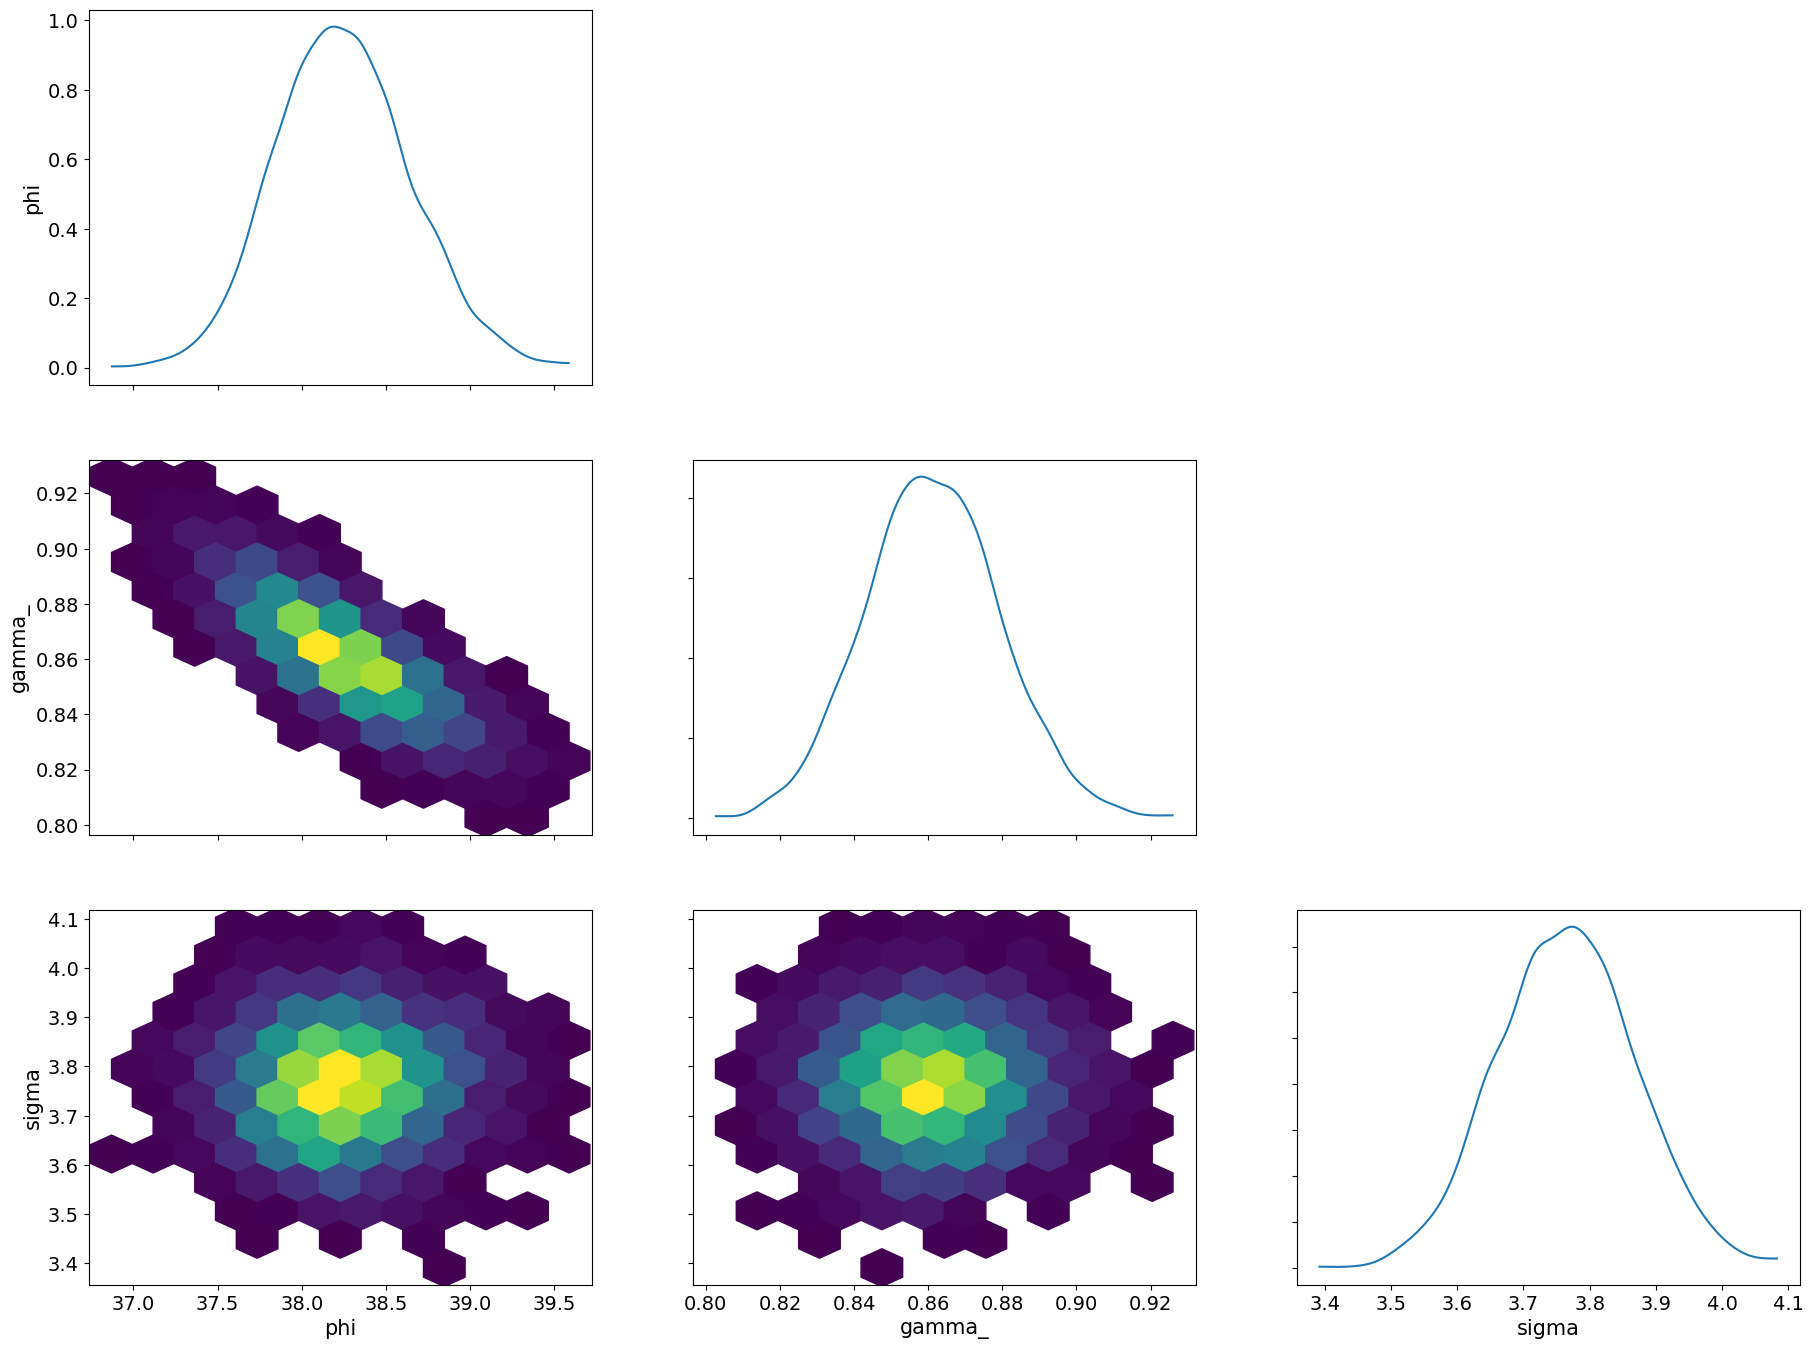

In [15]:
az.plot_pair(
    samples,
    var_names=["phi", "gamma_", "sigma"],
    kind="hexbin",
    marginals=True,
);

### Corner plots with bebi103

Corner plots are also implemented in the bebi103 package.

In [16]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[("phi", "ϕ [µm]"), ("gamma_", "γ"), ("sigma", "σ [µm]")],
        xtick_label_orientation=np.pi / 4,
    )
)

This is a nice way to summarize the posterior and is useful for visualizing how various parameters covary. We can also do a corner plot with the one-parameter marginalized posteriors represented as CDFs.

In [17]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[("phi", "ϕ [µm]"), ("gamma_", "γ"), ("sigma", "σ [µm]")],
        plot_ecdf=True,
        xtick_label_orientation=np.pi / 4,
    )
)

Corner plots are my preferred method of displaying results. All possible display-able marginal posteriors are plotted and laid out in a logical way.

In [18]:
bebi103.stan.clean_cmdstan()

## Computing environment

In [19]:
%load_ext watermark
%watermark -v -p numpy,pandas,cmdstanpy,arviz,bokeh,iqplot,bebi103,jupyterlab
print("cmdstan   :", bebi103.stan.cmdstan_version())

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.26.2
pandas    : 2.1.4
cmdstanpy : 1.2.0
arviz     : 0.17.0
bokeh     : 3.3.0
iqplot    : 0.3.5
bebi103   : 0.1.19
jupyterlab: 4.0.10

cmdstan   : 2.33.1
